In [1]:
from pytimeparse import parse

In [2]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

In [3]:
top_dir = None
with open('../configs/config.json') as f:
    top_dir = json.load(f)['top_dir']
pipeline_trace = pd.read_csv(os.path.join(top_dir,'results','pipeline_trace.csv'), sep='\t')

In [4]:
def read_datasets(pt):
    datasets = set()
    for ind in pt.index:
        dataset = pt['tag'][ind].split(":")[1]
        datasets.add(dataset)
    return list(datasets)

In [5]:
# from https://stackoverflow.com/questions/42865724/parse-human-readable-filesizes-into-bytes
units = {"B": 1, "KB": 10**3, "MB": 10**6, "GB": 10**9, "TB": 10**12}
def parse_size(size):
    number, unit = [string.strip() for string in size.split()]
    return int(float(number)*units[unit]/10**3)

In [6]:
def compute_rss_times(pt, tool_id):
    times = {}
    rss = {}
    for ind in pt.index:
        if tool_id in pt['name'][ind]:
            dataset = pt['tag'][ind].split(":")[1]
            if (pt['realtime'][ind] != '-'):
                time = parse(pt['realtime'][ind])
                times[dataset] = time
            else:
                times[dataset] = 0
            if (pt['peak_rss'][ind] != '-'):
                rss_ = parse_size(pt['peak_rss'][ind])
                rss[dataset] = rss_
            else:
                rss[dataset] = 0
    return times, rss

In [7]:
def compute_af_rss_times(pt, map_mode, gpl_mode):
    times = {}
    rss = {}
    for ind in pt.index:
        name = pt['name'][ind]
        dataset = pt['tag'][ind].split(":")[1]
        if 'af_' in name:
            if ('map' in name and map_mode in name) or \
            (('quant' in name or 'collate' in name or 'gpl' in name) and gpl_mode in name):
                if pt['realtime'][ind] != '-':
                    time = parse(pt['realtime'][ind])
                    if dataset not in times:
                        times[dataset] = time
                    else:
                        times[dataset] += time
                else:
                    times[dataset] = 0
                if pt['peak_rss'][ind] != '-':
                    rss_ = parse_size(pt['peak_rss'][ind])
                    if (dataset not in rss):
                        rss[dataset] = rss_
                    else:
                        rss[dataset] = max(rss_, rss[dataset])
                else:
                    rss[dataset] = 0
    return times, rss

In [8]:
times = {}
rss = {}

In [9]:
times['starsolo'], rss['starsolo'] = compute_rss_times(pipeline_trace, 'ss_')

In [10]:
times['kb'], rss['kb'] = compute_rss_times(pipeline_trace, 'kb_')

In [11]:
times['af_dense_knee'], rss['af_dense_knee'] = compute_af_rss_times(pipeline_trace, 'dense', 'knee')
times['af_sparse_knee'], rss['af_sparse_knee'] = compute_af_rss_times(pipeline_trace, 'sparse', 'knee')
times['af_dense_unfilt'], rss['af_dense_unfilt'] = compute_af_rss_times(pipeline_trace, 'dense', 'unfilt')
times['af_sparse_unfilt'], rss['af_sparse_unfilt'] = compute_af_rss_times(pipeline_trace, 'sparse', 'unfilt')

In [12]:
datasets = read_datasets(pipeline_trace)
tools = ['starsolo', 'kb', 'af_dense_knee', 'af_dense_unfilt', 'af_sparse_knee', 'af_sparse_unfilt']

In [13]:
all_times = pd.DataFrame(index = datasets, columns = tools)
all_rss = pd.DataFrame(index = datasets, columns = tools)

for dataset in datasets:
    for tool in tools:
        all_times.loc[dataset][tool] = times[tool][dataset]
        all_rss.loc[dataset][tool] = rss[tool][dataset]

In [14]:
ratios_knee = []
ratios_unfilt = []
for dataset in datasets:
    ratio_knee = all_times.loc[dataset]['af_sparse_knee'] / all_times.loc[dataset]['af_dense_knee']
    ratio_unfilt = all_times.loc[dataset]['af_sparse_unfilt'] / all_times.loc[dataset]['af_dense_unfilt']
    ratios_knee += [ratio_knee]
    ratios_unfilt += [ratio_unfilt]
all_times['sparse-dense knee ratio'] = ratios_knee
all_times['sparse-dense unfilt ratio'] = ratios_unfilt

In [15]:
ratios_knee = []
ratios_unfilt = []
for dataset in datasets:
    ratio_knee = all_rss.loc[dataset]['af_sparse_knee'] / all_rss.loc[dataset]['af_dense_knee']
    ratio_unfilt = all_rss.loc[dataset]['af_sparse_unfilt'] / all_rss.loc[dataset]['af_dense_unfilt']
    ratios_knee += [ratio_knee]
    ratios_unfilt += [ratio_unfilt]
all_rss['sparse-dense knee ratio'] = ratios_knee
all_rss['sparse-dense unfilt ratio'] = ratios_unfilt

In [16]:
datasets

['mouse_placenta', 'dr_pineal_s2', 'mouse_pancreas', 'sim_data', 'pbmc10k']

In [17]:
all_times

,starsolo,kb,af_dense_knee,af_dense_unfilt,af_sparse_knee,af_sparse_unfilt,sparse-dense knee ratio,sparse-dense unfilt ratio
mouse_placenta,2063,3243,1063,916.9,931,784.9,0.875823,0.856037
dr_pineal_s2,2058,1976,1038,833.6,1013,808.6,0.975915,0.970010
mouse_pancreas,4891,3953,2011,1878.5,1842,1709.5,0.915962,0.910035
sim_data,1297,1165,698.5,901,714.5,917,1.022906,1.017758
pbmc10k,2666,2579,1262,1576,1375,1689,1.089540,1.071701


In [18]:
all_rss

,starsolo,kb,af_dense_knee,af_dense_unfilt,af_sparse_knee,af_sparse_unfilt,sparse-dense knee ratio,sparse-dense unfilt ratio
mouse_placenta,27700000,57700000,6800000,6800000,4400000,4400000,0.647059,0.647059
dr_pineal_s2,15500000,4200000,4800000,4800000,3400000,3400000,0.708333,0.708333
mouse_pancreas,35100000,31200000,6200000,6200000,4200000,4200000,0.677419,0.677419
sim_data,30400000,4400000,8900000,8900000,6000000,6000000,0.674157,0.674157
pbmc10k,30500000,7000000,9900000,9900000,6700000,6700000,0.676768,0.676768


[Text(0, 0, 'mouse_placenta'),
 Text(1, 0, 'dr_pineal_s2'),
 Text(2, 0, 'mouse_pancreas'),
 Text(3, 0, 'sim_data'),
 Text(4, 0, 'pbmc10k')]

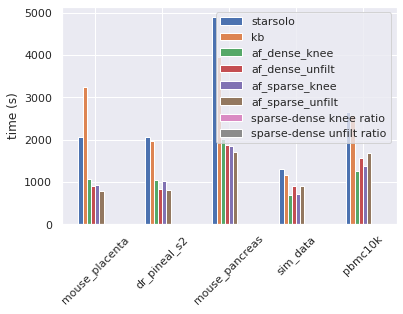

In [19]:
sns.set()
ax = all_times.plot.bar(ylabel = 'time (s)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

[Text(0, 0, 'mouse_placenta'),
 Text(1, 0, 'dr_pineal_s2'),
 Text(2, 0, 'mouse_pancreas'),
 Text(3, 0, 'sim_data'),
 Text(4, 0, 'pbmc10k')]

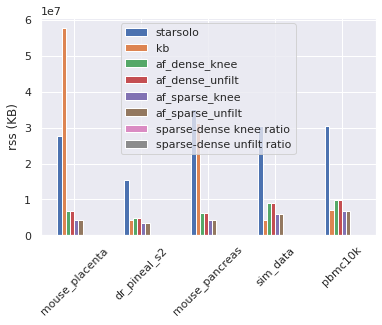

In [20]:
sns.set()
ax = all_rss.plot.bar(ylabel = 'rss (KB)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)